In [65]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
import seaborn as sns
import statsmodels.formula.api as smf
import os

%matplotlib inline

In [ ]:
os.chdir('C:\\Users\\liuth\\Documents\\Python Scripts\\ThinkfulProjects\\Data')

In [ ]:
#dataset from https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs
etf = pd.read_csv('ETFs.csv')
mf = pd.read_csv('MutualFunds.csv')

---

Exploring Data

In [4]:
etf.head(3)

In [5]:
mf.head(2)

---

Normalizing Net Assets

In [6]:
etfsort = etf.sort_values('net_assets', ascending=0)[['net_assets','fund_name', 'ytd_return', 'fund_yield', 'investment', 'size','fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']]
etf_2 = [math.sqrt(x) for x in etfsort['net_assets']]
etfsort = etfsort[['net_assets','fund_name', 'ytd_return', 'fund_yield', 'investment', 'size','fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']]
etfsort['net_assets'] = etf_2
etfsort.tail(5)

,net_assets,fund_name,ytd_return,fund_yield,investment,size,fund_sharpe_ratio_10years,fund_treynor_ratio_10years
1270,NaN,IWDP,7.94,3.73,Blend,Medium,0.71,11.79
1454,NaN,MFEG,NaN,0.00,Blend,Large,NaN,NaN
1494,NaN,MVOL,NaN,0.00,Blend,Large,NaN,NaN
1744,NaN,RCOM,NaN,NaN,NaN,NaN,NaN,NaN
2117,NaN,USDY,NaN,NaN,NaN,NaN,NaN,NaN


---

Cleaning and Validating Data

In [39]:
etfsort = etfsort.dropna()

---

Visualizing the data

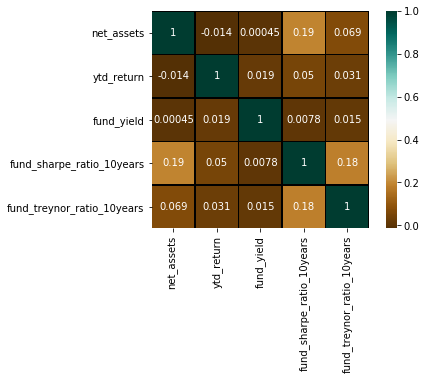

In [9]:
#Heat map ETF
sns.heatmap(etfsort.corr(),linewidths=0.25, square=True, cmap = "BrBG", linecolor='black', annot=True)

In [40]:
im=smf.ols(formula='ytd_return~fund_yield+fund_sharpe_ratio_10years+fund_treynor_ratio_10years+net_assets', data=etfsort).fit()

In [41]:
im.params
im.pvalues
im.rsquared
im.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ytd_return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.282
Date:                Thu, 25 Apr 2019   Prob (F-statistic):              0.275
Time:                        17:50:57   Log-Likelihood:                -6669.8
No. Observations:                1296   AIC:                         1.335e+04
Df Residuals:                    1291   BIC:                         1.338e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     21.1936      1.406     15.074      0.000      18.435      23.952
fund_yield                     0.0882      0.136      0.651      0.515      -0.178       0.354
fund_sharpe_ratio_10years      0.6768      0.384      1.764      0.078      -0.076       1.430
fund_treynor_ratio_10years     0.0405      0.050      0.809      0.418      -0.058       0.139
net_assets                 -1.159e-05   1.27e-05     -0.913      0.362   -3.65e-05    1.33e-05
==============================================================================
Omnibus:                     1489.211   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           142989.128
Skew:                           5.761   Prob(JB):                         0.00
Kurtosis:                      53.152   Cond. No.                     1.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

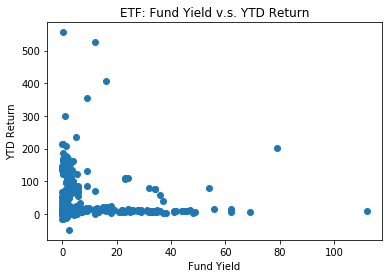

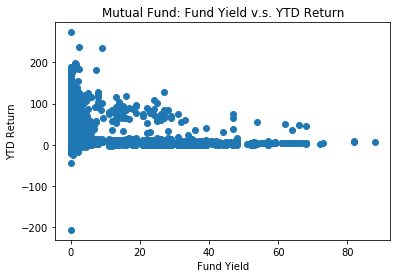

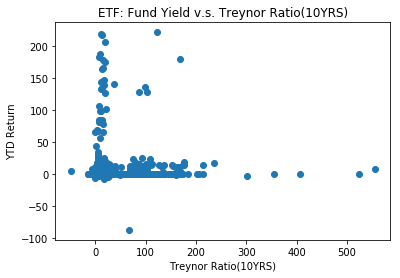

In [11]:
plt.scatter(etfsort.fund_yield, etfsort.ytd_return)
plt.title("ETF: Fund Yield v.s. YTD Return")
plt.ylabel("YTD Return")
plt.xlabel("Fund Yield")
plt.show()

plt.scatter(mfsort.fund_yield, mfsort.ytd_return)
plt.title('Mutual Fund: Fund Yield v.s. YTD Return')
plt.ylabel('YTD Return')
plt.xlabel('Fund Yield')
plt.show()

plt.scatter(etfsort.ytd_return, etfsort.fund_treynor_ratio_10years)
plt.title('ETF: Fund Yield v.s. Treynor Ratio(10YRS)')
plt.ylabel('YTD Return')
plt.xlabel('Treynor Ratio(10YRS)')
plt.show()


---

Building the Model (I am not understanding why I had to scale it, if I did not scale it, I ran into issues)

In [19]:
regr = linear_model.LinearRegression()
Y = etfsort['ytd_return']
X = etfsort[['fund_yield','fund_sharpe_ratio_10years','fund_treynor_ratio_10years','net_assets']]
regr.fit(X, Y)

# Review results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared \n:', regr.score(X, Y))


Coefficients: 
 [ 8.82137507e-02  6.76836084e-01  4.05497946e-02 -1.15935182e-05]

Intercept: 
 21.19360150495818

R-squared 
: 0.003956277338847847


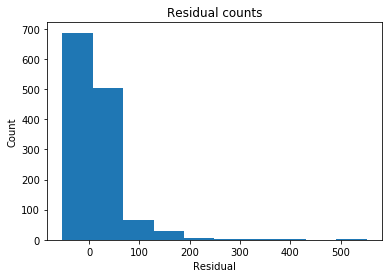

In [18]:
#multivariate normality
predicted = regr.predict(X).ravel()
actual = etfsort['ytd_return']
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [33]:
#ADJUST FOR SKEWNESS
regr = linear_model.LinearRegression()
Y = etfsort['ytd_return'].values.reshape(-1, 1)
X = etfsort[['fund_yield', 'fund_sharpe_ratio_10years','fund_treynor_ratio_10years','net_assets']]
netasset_2 = [math.sqrt(x) for x in etfsort['net_assets']]
X = etfsort[['fund_yield','fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']]
X['netasset_2'] = netasset_2
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.0898424   0.67605064  0.04209954 -0.00674901]]

Intercept: 
 [21.76196012]

R-squared:
0.00358520163798548


C:\Users\liuth\WPy-3670\python-3.6.7.amd64\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


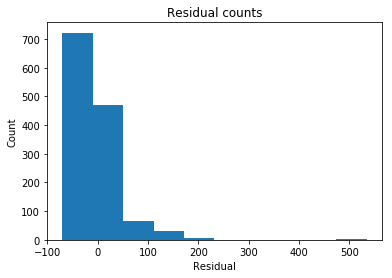

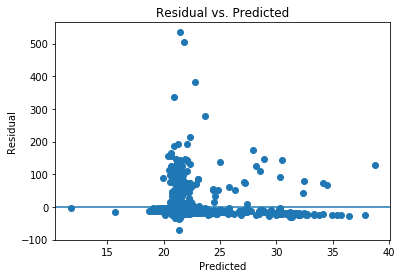

In [34]:
predicted = regr.predict(X).ravel()
actual = etfsort['ytd_return']

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
axes = plt.gca()
plt.title('Residual vs. Predicted')
plt.show()

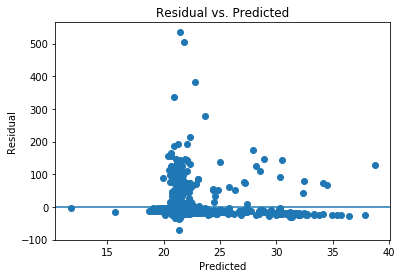

In [35]:
#Homoscedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [36]:
correlation_matrix = X.corr()
correlation_matrix

,fund_yield,fund_sharpe_ratio_10years,fund_treynor_ratio_10years,netasset_2
fund_yield,1.000000,0.007810,0.014953,0.020631
fund_sharpe_ratio_10years,0.007810,1.000000,0.184365,0.295111
fund_treynor_ratio_10years,0.014953,0.184365,1.000000,0.153210
netasset_2,0.020631,0.295111,0.153210,1.000000


---

Accuracy Test for the OLS Model

In [42]:
score = cross_val_score(regr, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: -0.04 (+/- 0.12)


---

KNN Modeling

In [59]:
etfint = etfsort['ytd_return'].astype(int)

In [66]:
neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

X = etfsort[['fund_sharpe_ratio_10years','fund_treynor_ratio_10years','net_assets']]
Y = etfint

neighbors.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

In [75]:
score = cross_val_score(neighbors, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.02 (+/- 0.04)


C:\Users\liuth\WPy-3670\python-3.6.7.amd64\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


---

Explainations:
The KNN model was accurate because there was more clumping than there were continuous trends.  Both models were however, grossly inaccurate.  Perhaps its due to the fact that none of these values correlated.  These indicators for the ETFs were greatly misleading and serve no purpose.  Perhaps this is due to Yahoo's way of calculating the sharpe ratio and treynor ratio and in turn was compared to daily calculations.  This was an inconclusive study and needs further exploration.